In [1]:
import numpy
import numpy as np
import os
import xray
import netCDF4
from scipy import stats
from scipy import io
from scipy import linalg as lin
from sstanalysis import gfd
from netCDF4 import Dataset
from tempfile import TemporaryFile
from scipy import interpolate as naiso
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sstanalysis import popmodel
reload(popmodel)

<module 'sstanalysis.popmodel' from 'sstanalysis/popmodel.pyc'>

In [3]:
import ipyparallel as ipp
ipp.__path__

['/usr/local/anaconda/lib/python2.7/site-packages/ipyparallel']

In [4]:
c = ipp.Client(profile='parallel2') 
dview = c.direct_view() 
lview = c.load_balanced_view() 

In [5]:
with dview.sync_imports():
    import numpy
    import os
    import netCDF4
    import warnings
    import xray
    from scipy import io
    from scipy import interpolate
    from matplotlib import pyplot
    from scipy import linalg
    from scipy import signal
    from scipy import fftpack
    from warnings import warn
    #from sstanalysis import popmodel

importing numpy on engine(s)
importing os on engine(s)
importing netCDF4 on engine(s)
importing warnings on engine(s)
importing xray on engine(s)
importing io from scipy on engine(s)
importing interpolate from scipy on engine(s)
importing pyplot from matplotlib on engine(s)
importing linalg from scipy on engine(s)
importing signal from scipy on engine(s)
importing fftpack from scipy on engine(s)
importing warn from warnings on engine(s)


In [6]:
dlat, dlon = (10., 10.)
lat_start, lat_end = (-60., 50.)
lon_start, lon_end = (5., 345.)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)
Degx, Degy = (int((lon_end-lon_start)/dlon), int((lat_end-lat_start)/dlat))
lon_global = np.arange(lon_start, lon_end+2*dlon, dlon)
lat_global = np.arange(lat_start, lat_end+2*dlat, dlat)
Lon_global, Lat_global = np.meshgrid(lon_global, lat_global)
psd_slopes_Feb_global = np.zeros((Degy+1,Degx+1))
#psd_slopes_Aug_global = np.zeros((Degy+1,Degx+1))
psd_level_Feb_global = np.zeros((Degy+1,Degx+1))
#psd_level_Aug_global = np.zeros((Degy+1,Degx+1))
L_1_global = np.zeros((Degy+1,Degx+1)) 
# base_dir = '/home/../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

print Degx, Degy, (Degx+1)*(Degy+1)
print Lon_global.shape

34 11 420
(13, 36)


In [7]:
roll = -1080

# base_dir = '/data/scratch/takaya/POP_data/Surface_Daily'
base_dir = '/data/scratch/takaya/POP_data/Surface_Daily/'
fname = os.path.join(base_dir, 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc')
f = xray.open_dataset(fname, decode_times=False)
mask = f.variables['KMT'].values <= 1
SSS = f.variables['SSS'].values
tlon = np.roll(np.ma.masked_array(f.variables['TLONG'].values, mask), roll, axis=1)
tlat = np.roll(np.ma.masked_array(f.variables['TLAT'].values, mask), roll, axis=1)
Dz = f['dz'].values[0]*1e-2 


lonrange=np.array([lon_start, lon_end])
latrange=np.array([lat_start, lat_end+5.])
lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
boxidx = lonmask & latmask # this won't necessarily be square
irange = np.where(boxidx.sum(axis=0))[0]
imin_bound, imax_bound = irange.min(), irange.max()
jrange = np.where(boxidx.sum(axis=1))[0]
jmin_bound, jmax_bound = jrange.min(), jrange.max()


npzfile = np.load('interpLatnLon.npz')
print npzfile.files
tlat = npzfile['arr_0']
tlon = npzfile['arr_1']

['arr_1', 'arr_0']


In [8]:
N = 128
isospecs_ave_Tforc = np.zeros(( (Degy+1)*(Degx+1), N ))
isospecs_ave_Tdiss = np.zeros(( (Degy+1)*(Degx+1), N ))
isospecs_ave_Sforc = np.zeros(( (Degy+1)*(Degx+1), N ))
isospecs_ave_Sdiss = np.zeros(( (Degy+1)*(Degx+1), N ))
isospecs_ave_Tadvt = np.zeros(( (Degy+1)*(Degx+1), N ))
isospecs_ave_Sadvt = np.zeros(( (Degy+1)*(Degx+1), N ))
Mr = np.zeros(( (Degy+1)*(Degx+1), N ))
#Deg_Free = np.zeros(M)
print isospecs_ave_Tdiss.shape, Degx, Degy

(420, 128) 34 11


In [9]:
month = 9
# year = 41
year = 6
fname_mat = ['' for x in range(year)]

for yearnum in range(year):
    fname = os.path.join(base_dir,
                                 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.%04d-%02d-01.nc' 
                                 % (yearnum+46, month))
    fname_mat[yearnum] = fname
    f = netCDF4.Dataset(fname)
#     print yearnum+46
        
    #for i in range(Nt):
        #SSH_masked[i] = 1e-2*np.roll(np.ma.masked_array(f.variables['SSH_2'][i],mask), roll, axis=1)
    
    #SSH_full[Nt*yearnum:Nt*yearnum+Nt] = SSH_masked[:, jmin_bound:jmax_bound+100, imin_bound:imax_bound+100] 
    
mask_global = np.roll(mask, roll, axis=1)[jmin_bound:jmax_bound+100, imin_bound:imax_bound+100]
print fname_mat
    
Ny, Nx = tlon.shape
    
dview.scatter('fname_mat', fname_mat)
dview['Nx_global'] = Nx
dview['Ny_global'] = Ny
dview['tlon'] = tlon
dview['tlat'] = tlat
dview['mask_global'] = mask_global
dview['imin_bound'] = imin_bound
dview['imax_bound'] = imax_bound
dview['jmin_bound'] = jmin_bound
dview['jmax_bound'] = jmax_bound
dview['lon_start'] = lon_start
dview['lon_end'] = lon_end
dview['lat_start'] = lat_start
dview['lat_end'] = lat_end
dview['dlat'] = dlat
dview['dlon'] = dlon
dview['Degx'] = Degx
dview['Degy'] = Degy
dview['N'] = N
dview['Dz'] = Dz

['/data/scratch/takaya/POP_data/Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-09-01.nc', '/data/scratch/takaya/POP_data/Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0047-09-01.nc', '/data/scratch/takaya/POP_data/Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0048-09-01.nc', '/data/scratch/takaya/POP_data/Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0049-09-01.nc', '/data/scratch/takaya/POP_data/Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0050-09-01.nc', '/data/scratch/takaya/POP_data/Surface_Daily/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0051-09-01.nc']


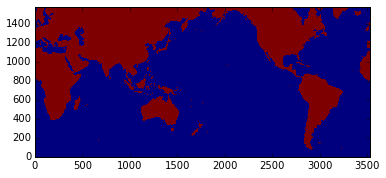

In [ ]:
plt.imshow(mask_global, origin='bottom')

In [10]:
%%px

def calc_transformation_rates(pop_fname, dz):
    
    #p = pop_model.POPFile(pop_fname, hconst=dz)
    p = popmodel.POPFile(pop_fname, hconst=dz)
    p.initialize_gradient_operator()
    #Nt = len(p.nc.variables['time'])
    #Ny, Nx = p.nc.variables['TLONG'].shape
    Nt = len(p.nc['time'])
    Ny, Nx = p.nc['TLONG'].shape
    Tdot_month = numpy.zeros((Nt, Ny, Nx))
    Tmix_month = numpy.zeros_like(Tdot_month)
    Sdot_month = numpy.zeros_like(Tdot_month)
    Smix_month = numpy.zeros_like(Tdot_month)
    
#     result = dict()
#     for rname in region_dict:
#         result[rname] = 0.
    
    for n in range(Nt):
#         print 'day: ', n
        
        # calculate density fluxes
        T, S, FT_forc, FT_mix, FS_forc, FS_mix = p.ts_forcing[n]
        FS_mix = numpy.ma.masked_greater(numpy.ma.masked_invalid(FS_mix), 1.)
        FT_mix = numpy.ma.masked_greater(numpy.ma.masked_invalid(FT_mix), 1.)
        Tdot_month[n] = FT_forc
        Sdot_month[n] = FS_forc
        Tmix_month[n] = FT_mix
        Smix_month[n] = FS_mix
        
#         for rname, reg in region_dict.iteritems():
#             AT, AS = reg.calculate_transformation_rate(
#                                 T, S, [FT_forc, FT_mix], [FS_forc, FS_mix])
#             result[rname] += numpy.array([AT, AS])

#     for rname in region_dict:
#         result[rname] /= Nt
    
    return p, Tdot_month, Tmix_month, Sdot_month, Smix_month

In [11]:
%%px

def calc_gradient(pop_fname, dz):
    
    p = popmodel.POPFile(pop_fname, hconst=dz)
    #p = popmodel.POPFile(pop_fname)
    p.initialize_gradient_operator()
    #Nt = len(p.nc.variables['time'])
    #Ny, Nx = p.nc.variables['TLONG'].shape
    Nt = len(p.nc['time'])
    Ny, Nx = p.nc['TLONG'].shape
#     gradTx_month = np.zeros((Nt, Ny, Nx))
#     gradTy_month = np.zeros_like(gradTx_month)
#     gradSx_month = np.zeros_like(gradTx_month)
#     gradSy_month = np.zeros_like(gradTx_month)
    
#     result = dict()
#     for rname in region_dict:
#         result[rname] = 0.
    
#     print p.nc['SST']
    mask, gradTx, gradTy = p.gradient_2d(varname='SST', roll=0)
    mask, gradSx, gradSy = p.gradient_2d(varname='SSS', roll=0)
#         gradTx_month[n] = gradTx
#         gradSx_month[n] = gradSx
#         gradTy_month[n] = gradTy
#         gradSy_month[n] = gradSy
        
#         for rname, reg in region_dict.iteritems():
#             AT, AS = reg.calculate_transformation_rate(
#                                 T, S, [FT_forc, FT_mix], [FS_forc, FS_mix])
#             result[rname] += numpy.array([AT, AS])

#     for rname in region_dict:
#         result[rname] /= Nt
    
    return p, mask, gradTx, gradTy, gradSx, gradSy

In [12]:
%%px

import sys
sys.path.append('/home/takaya/sst_analysis/sstanalysis')
import popmodel
reload(popmodel)


crit = 0.01
j,i = (0,0)
west, south = (lon_start, lat_start)
east, north = (west+dlon, south+dlat)
#Lon_global, Lat_global = numpy.meshgrid(lon_global, lat_global)
nanarray = numpy.zeros(N)
nanarray[:] = numpy.NAN

isospecs_month_T_forc = numpy.zeros(((Degx+1)*(Degy+1), N))
isospecs_month_S_forc = isospecs_month_T_forc.copy()
isospecs_month_T_diss = isospecs_month_T_forc.copy()
isospecs_month_S_diss = isospecs_month_T_forc.copy()
isospecs_month_T_advt = isospecs_month_T_forc.copy()
isospecs_month_S_advt = isospecs_month_T_forc.copy()
isospecs_month_S_advt = isospecs_month_T_forc.copy()
Kis_month = isospecs_month_T_forc.copy()
Mrs_month = isospecs_month_T_forc.copy()

In [13]:
%%px

for yearnum in range(len(fname_mat)):
    
    
#     print fname_mat[yearnum]
    
    p, Tdot, Tmix, Sdot, Smix = calc_transformation_rates(fname_mat[yearnum], Dz)
    print p

    p.nc['T_forc'] = xray.DataArray( Tdot, dims=p.nc['SST'].dims, coords=p.nc['SST'].coords )
    p.nc['S_forc'] = xray.DataArray( Sdot, dims=p.nc['SSS'].dims, coords=p.nc['SSS'].coords )
    p.nc['T_diss'] = xray.DataArray( Tmix, dims=p.nc['SST'].dims, coords=p.nc['SST'].coords )
    p.nc['S_diss'] = xray.DataArray( Smix, dims=p.nc['SSS'].dims, coords=p.nc['SSS'].coords )
    
    q, mask_grad, gradSSTx, gradSSTy, gradSSSx, gradSSSy = calc_gradient(fname_mat[yearnum], Dz)
    print q

    q.nc['gradTx'] = xray.DataArray( gradSSTx, dims=q.nc['U1_1'].dims, coords=q.nc['U1_1'].coords )
    q.nc['gradTy'] = xray.DataArray( gradSSTy, dims=q.nc['V1_1'].dims, coords=q.nc['V1_1'].coords )
    q.nc['gradSx'] = xray.DataArray( gradSSSx, dims=q.nc['U1_1'].dims, coords=q.nc['U1_1'].coords )
    q.nc['gradSy'] = xray.DataArray( gradSSSy, dims=q.nc['V1_1'].dims, coords=q.nc['V1_1'].coords )
     
    
    
    while south < lat_end+dlat:
        west = lon_start
        east = west+dlon
        i = 0
        while west < lon_end+dlon:
            
#             print east, west, south, north
            
            lonrange = numpy.array([west, east])
            latrange = numpy.array([south, north])
            lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
            latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
            boxidx = lonmask & latmask # this won't necessarily be square
            irange = numpy.where(boxidx.sum(axis=0))[0]
            imin, imax = irange.min(), irange.max()
            jrange = numpy.where(boxidx.sum(axis=1))[0]
            jmin, jmax = jrange.min(), jrange.max()

            region_mask = mask_global[jmin:jmax, imin:imax]
            Ny, Nx = region_mask.shape
            land_fraction = region_mask.sum().astype('f8') / (Ny*Nx)
            #SSH_domain = SSH[..., jmin:jmax, imin:imax]

    
            if south < lat_end+dlat:
                if west < lon_end+dlon:
                    if land_fraction<crit:
                    #print 'Index range (i): ', imin, imax
                    #print 'Index range (j): ', jmin, jmax
                    # February
                    #NtFeb = 0.
                    # load data files

                        
                        # Temperature forcing
                        Neff, Nt_month, Nx, Ny, k, l, spatial, tilde, breve, Ki, isospec, area, land_frac, MAX_LAND = p.spectrum_2d(
                                                varname='SST', tendname='T_forc', crossspec=True, detrend=True, roll=-1080, 
                                                xmin=imin, xmax=imax, ymin=jmin, ymax=jmax, 
                                                ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)
                        
                        isospecs_month_T_forc[(Degx+1)*j+i] += isospec
#                         print 'Temp forcing OK'

                        
                        # Salinity forcing
                        Neff, Nt_month, Nx, Ny, k, l, spatial, tilde, breve, Ki, isospec, area, land_frac, MAX_LAND = p.spectrum_2d(
                                                varname='SSS', tendname='S_forc', crossspec=True, detrend=True, roll=-1080, 
                                                xmin=imin, xmax=imax, ymin=jmin, ymax=jmax, 
                                                ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)

                        isospecs_month_S_forc[(Degx+1)*j+i] += isospec
#                         if yearnum == len(fname)-1:
#                             isospecs_month_S_forc[(Degx+1)*j+i] = isospec_sum_month_Sf[(Degx+1)*j+i]
#                         print 'Salinity forcing OK'

                        
                        # Temperature dissipation
                        Neff, Nt_month, Nx, Ny, k, l, spatial, tilde, breve, Ki, isospec, area, land_frac, MAX_LAND = p.spectrum_2d(
                                                varname='SST', tendname='T_diss', crossspec=True, detrend=False, roll=-1080, 
                                                xmin=imin, xmax=imax, ymin=jmin, ymax=jmax, 
                                                ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)        
                        
                        isospecs_month_T_diss[(Degx+1)*j+i] += isospec
#                         if yearnum == len(fname)-1:
#                             isospecs_month_T_diss[(Degx+1)*j+i] = isospec_sum_month_Td[(Degx+1)*j+i]
#                         print 'Temp dissipation OK'


                        # Salinity dissipation
                        Neff, Nt_month, Nx, Ny, k, l, spatial, tilde, breve, Ki, isospec, area, land_frac, MAX_LAND = p.spectrum_2d(
                                                varname='SSS', tendname='S_diss', crossspec=True, detrend=False, roll=-1080, 
                                                xmin=imin, xmax=imax, ymin=jmin, ymax=jmax, 
                                                ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)

                        isospecs_month_S_diss[(Degx+1)*j+i] += isospec
#                         if yearnum == len(fname)-1:
#                             isospecs_month_S_diss[(Degx+1)*j+i] = isospec_sum_month_Sd[(Degx+1)*j+i]
#                         print 'Salinity dissipation OK'

                        
                        # Temperature advection
                        Neff, Nt_month, Nx, Ny, k, l, spatial, tilde, breve, Ki, isospec, area, land_frac, MAX_LAND = q.spectrum_2d(
                                                varname='SST', gradxname='gradTx', gradyname='gradTy', advt=True, detrend=True, roll=-1080, 
                                                xmin=imin, xmax=imax, ymin=jmin, ymax=jmax, 
                                                ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)
                     
                        isospecs_month_T_advt[(Degx+1)*j+i] += isospec
#                         if yearnum == len(fname)-1:
#                             isospecs_month_T_advt[(Degx+1)*j+i] = isospec_sum_month_Ta[(Degx+1)*j+i]
#                         print 'Temp advection OK'
    
                        
                        # Salinity advection
                        Neff, Nt_month, Nx, Ny, k, l, spatial, tilde, breve, Ki, isospec, area, land_frac, MAX_LAND = q.spectrum_2d(
                                                varname='SSS', gradxname='gradSx', gradyname='gradSy', advt=True, detrend=True, roll=-1080, 
                                                xmin=imin, xmax=imax, ymin=jmin, ymax=jmax, 
                                                ymin_bound=jmin_bound, ymax_bound=jmax_bound, xmin_bound=imin_bound, xmax_bound=imax_bound)

                        isospecs_month_S_advt[(Degx+1)*j+i] += isospec
#                         print 'Salinity advection OK'
                        if yearnum == 0:
#                             isospecs_month_S_advt[(Degx+1)*j+i] = isospec_sum_month_Sa[(Degx+1)*j+i]
                            Kis_month[(Degx+1)*j+i] = Ki
                            Mrs_month[(Degx+1)*j+i] = area
                        
               
                    else:
                        if yearnum == 0:
                            isospecs_month_T_forc[(Degx+1)*j+i] = nanarray
                            isospecs_month_S_forc[(Degx+1)*j+i] = nanarray
                            isospecs_month_T_diss[(Degx+1)*j+i] = nanarray
                            isospecs_month_S_diss[(Degx+1)*j+i] = nanarray
                            isospecs_month_T_advt[(Degx+1)*j+i] = nanarray
                            isospecs_month_S_advt[(Degx+1)*j+i] = nanarray
                            Kis_month[(Degx+1)*j+i] = nanarray
                            Mrs_month[(Degx+1)*j+i] = nanarray
                        else:
                            pass
                        #if (Degx+1)*j+i>=400:
                        #    print (Degx+1)*j+i
                        #    print isospecs_month[(Degx+1)*j+i]
                        #print 'Too much land coverage'
                        #Lon_global[j,i] = tlon[jmin,imin]
                        #Lat_global[j,i] = tlat[jmin,imin]
                        #Lon_max[j,i] = tlon[jmin,imax]
                        #Lat_max[j,i] = tlat[jmax,imin]
                        #Lon_upright_corn = tlon[jmax,imax]
                        #Lat_upright_corn = tlat[jmax,imax]
                        #psd_slopes_Feb_global[j,i] = np.nan
                        #psd_slopes_Aug_global[j,i] = np.nan
                        #psd_level_Feb_global[j,i] = np.nan
                        #psd_level_Aug_global[j,i] = np.nan
                        #L_1_global[j,i] = np.nan
            
                        #plt.figure(figsize=(15,4))
                        #plt.subplot(121)
                        #plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain)
                        #plt.title('SST (Land coverage: %g)' % land_frac, fontsize=16)
                        #plt.xticks(fontsize=14)
                        #plt.yticks(fontsize=14)
                #else:
                    #Lon_global[j,i] = tlon[jmin,imin]
                    #Lat_global[j,i] = tlat[jmin,imin]
            #else:
                #Lon_global[j,i] = tlon[jmin,imin]
                #Lat_global[j,i] = tlat[jmin,imin]
        
            #if i>0:
                #print 'Zonal range is: ', Lon_global[j,i-1], Lon_global[j,i]
            #if j>0 and i==0:
                #print '  Meridional range is: ', Lat_global[j-1,i], Lat_global[j,i]
            west = east
            east = west+dlon
            i += 1
    
        south = north
        north = south+dlat
        j += 1
    
  

[stdout:0] 
[stdout:1] 


[stderr:0] 
/home/takaya/sst_analysis/sstanalysis/popmodel.py:105: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  self._ahf[self.mask] = 0.
/home/takaya/sst_analysis/sstanalysis/popmodel.py:465: UserWarning: The sector has land (land_fraction=0.000522466) but we are interpolating it out.
  warnings.warn(errstr)
/home/takaya/sst_analysis/sstanalysis/popmodel.py:465: UserWarning: The sector has land (land_fraction=0.000174155) but we are interpolating it out.
  warnings.warn(errstr)
/home/takaya/sst_analysis/sstanalysis/popmodel.py:465: UserWarning: The sector has land (land_fraction=0.000928829) but we are interpolating it out.
  warnings.warn(errstr)
/home/takaya/sst_analysis/sstanalysis/popmodel.py:465: UserWarning: The sector has land (land_fraction=0.00267038) but we are interpolating it out.
  warnings.warn(errstr)
/home/takaya/sst_analysis/sstanalysis/popmodel.py:465: UserWarning: The sector has land (land_fraction=0.0049344) but we ar

In [14]:
%%px

isospecs_T_forc = numpy.reshape(isospecs_month_T_forc.copy(), (Degx+1)*(Degy+1)*N)
isospecs_S_forc = numpy.reshape(isospecs_month_S_forc.copy(), (Degx+1)*(Degy+1)*N)
isospecs_T_diss = numpy.reshape(isospecs_month_T_diss.copy(), (Degx+1)*(Degy+1)*N)
isospecs_S_diss = numpy.reshape(isospecs_month_S_diss.copy(), (Degx+1)*(Degy+1)*N)
isospecs_T_advt = numpy.reshape(isospecs_month_T_advt.copy(), (Degx+1)*(Degy+1)*N)
isospecs_S_advt = numpy.reshape(isospecs_month_S_advt.copy(), (Degx+1)*(Degy+1)*N)
Kis = numpy.reshape(Kis_month.copy(), (Degx+1)*(Degy+1)*N)
Mrs = numpy.reshape(Mrs_month.copy(), (Degx+1)*(Degy+1)*N)

In [15]:
Neff = dview['Neff']
isospecs_full_month_T_forc = dview.gather('isospecs_T_forc').get()
isospecs_full_month_S_forc = dview.gather('isospecs_S_forc').get()
isospecs_full_month_T_diss = dview.gather('isospecs_T_diss').get()
isospecs_full_month_S_diss = dview.gather('isospecs_S_diss').get()
isospecs_full_month_T_advt = dview.gather('isospecs_T_advt').get()
isospecs_full_month_S_advt = dview.gather('isospecs_S_advt').get()
Kis_full_month = dview.gather('Kis').get()
Mrs_full_month = dview.gather('Mrs').get()

#############
cluster_num = 2
#############
isospecs_full_T_forc = np.reshape(isospecs_full_month_T_forc,
                                  (cluster_num, isospecs_full_month_T_forc.shape[0]/N/cluster_num,N))
isospecs_full_S_forc = np.reshape(isospecs_full_month_S_forc,
                                  (cluster_num, isospecs_full_month_S_forc.shape[0]/N/cluster_num,N))
isospecs_full_T_diss = np.reshape(isospecs_full_month_T_diss,
                                  (cluster_num, isospecs_full_month_T_diss.shape[0]/N/cluster_num,N))
isospecs_full_S_diss = np.reshape(isospecs_full_month_S_diss,
                                  (cluster_num, isospecs_full_month_S_diss.shape[0]/N/cluster_num,N))
isospecs_full_T_advt = np.reshape(isospecs_full_month_T_advt,
                                  (cluster_num, isospecs_full_month_T_advt.shape[0]/N/cluster_num,N))
isospecs_full_S_advt = np.reshape(isospecs_full_month_S_advt,
                                  (cluster_num, isospecs_full_month_S_advt.shape[0]/N/cluster_num,N))
Kis = np.reshape(Kis_full_month, 
                 (cluster_num, isospecs_full_month_T_advt.shape[0]/N/cluster_num,N))[0]
Mrs = np.reshape(Mrs_full_month, 
                 (cluster_num, isospecs_full_month_T_advt.shape[0]/N/cluster_num,N))[0]

year_num = year
isospecs_ave_Tforc = isospecs_full_T_forc.sum(axis=0)/(year_num*Neff[0]) 
isospecs_ave_Tdiss = isospecs_full_T_diss.sum(axis=0)/(year_num*Neff[0]) 
isospecs_ave_Sforc = isospecs_full_S_forc.sum(axis=0)/(year_num*Neff[0]) 
isospecs_ave_Sdiss = isospecs_full_S_diss.sum(axis=0)/(year_num*Neff[0]) 
isospecs_ave_Tadvt = isospecs_full_T_advt.sum(axis=0)/(year_num*Neff[0]) 
isospecs_ave_Sadvt = isospecs_full_S_advt.sum(axis=0)/(year_num*Neff[0]) 
Deg_Free = Neff[0]*year_num*Mrs
print isospecs_ave_Tforc.shape, isospecs_full_T_forc.sum(axis=0).shape, Deg_Free

(420, 128) (420, 128) [[    0.    18.    36. ...,  3888.  3852.  2952.]
 [    0.    18.    36. ...,  3888.  3852.  2952.]
 [    0.    18.    36. ...,  3888.  3852.  2952.]
 ..., 
 [    0.    18.    36. ...,  2232.  3024.  2376.]
 [    0.    18.    36. ...,  2340.  2412.  2088.]
 [   nan    nan    nan ...,    nan    nan    nan]]


In [ ]:
# year_num = year
# isospecs_ave_Tforc = isospecs_month_T_forc/(year_num*Neff) 
# isospecs_ave_Tdiss = isospecs_month_T_diss/(year_num*Neff) 
# isospecs_ave_Sforc = isospecs_month_S_forc/(year_num*Neff) 
# isospecs_ave_Sdiss = isospecs_month_S_diss/(year_num*Neff) 
# isospecs_ave_Tadvt = isospecs_month_T_advt/(year_num*Neff) 
# isospecs_ave_Sadvt = isospecs_month_S_advt/(year_num*Neff) 
# Deg_Free = Neff*year_num*area
# # print isospecs_ave_Tforc.shape, isospecs_full_T_forc.sum(axis=0).shape, Deg_Free

In [ ]:
# Kis = Kis_month

In [ ]:
# np.savez('SSTSSStendency_test_January_parallel', 
#          Tforc=isospecs_ave_Tforc, Sforc=isospecs_ave_Sforc,
#          Tdiss=isospecs_ave_Tdiss, Sdiss=isospecs_ave_Sdiss,
#          Tadvt=isospecs_ave_Tadvt, Sadvt=isospecs_ave_Sadvt,
#          Ki=Kis, Deg_Freedom=Deg_Free)

In [31]:
# npzfile = np.load('SSTSSStendency_test_January_parallel.npz')
# print npzfile.files
# Tforc_test = npzfile['Tforc']
# Kis = npzfile['Ki']
# Neff_Jan = npzfile['Deg_Freedom']

['Tdiss', 'Sadvt', 'Deg_Freedom', 'Sforc', 'Sdiss', 'Tforc', 'Tadvt', 'Ki']


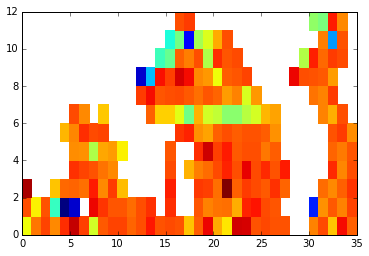

In [36]:
# Tforc_test_Jan = np.reshape(Tforc_test_Jan, ((Degy+1), (Degx+1), N))
# plt.pcolormesh(np.ma.masked_invalid(Tforc_test_Jan[:,:,1]))

In [16]:
np.savez('SSTSSStendency_September_parallel', 
         Tforc=isospecs_ave_Tforc, Sforc=isospecs_ave_Sforc,
         Tdiss=isospecs_ave_Tdiss, Sdiss=isospecs_ave_Sdiss,
         Tadvt=isospecs_ave_Tadvt, Sadvt=isospecs_ave_Sadvt,
         Ki=Kis, Deg_Freedom=Deg_Free)

In [17]:
npzfile = np.load('SSTSSStendency_September_parallel.npz')
print npzfile.files
Tforc = npzfile['Tforc']
Kis = npzfile['Ki']
Neff_Jan = npzfile['Deg_Freedom']

['Tdiss', 'Sadvt', 'Deg_Freedom', 'Sforc', 'Sdiss', 'Tforc', 'Tadvt', 'Ki']


<matplotlib.colorbar.Colorbar instance at 0x7f9db82b4c68>

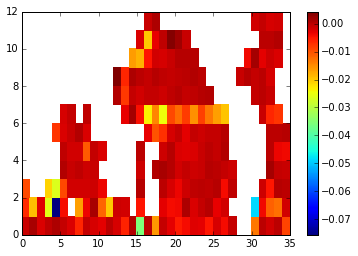

In [18]:
Tforc_Sep = np.reshape(Tforc, ((Degy+1), (Degx+1), N))
plt.pcolormesh(np.ma.masked_invalid(Tforc_Sep[:,:,1]))
plt.colorbar()

In [3]:
print Kis

[[  0.00000000e+00   6.14636710e-07   1.22927342e-06 ...,   7.68295887e-05
    7.74442254e-05   7.80588621e-05]
 [  0.00000000e+00   6.14636710e-07   1.22927342e-06 ...,   7.68295887e-05
    7.74442254e-05   7.80588621e-05]
 [  0.00000000e+00   6.14636710e-07   1.22927342e-06 ...,   7.68295887e-05
    7.74442254e-05   7.80588621e-05]
 ..., 
 [  0.00000000e+00   4.84584047e-07   9.69168094e-07 ...,   6.05730059e-05
    6.10575899e-05   6.15421740e-05]
 [  0.00000000e+00   4.76839200e-07   9.53678400e-07 ...,   5.96049000e-05
    6.00817392e-05   6.05585784e-05]
 [             nan              nan              nan ...,              nan
               nan              nan]]
